# Data Load

In [ ]:
from google.colab import drive

# 드라이브 마운트
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip /content/drive/MyDrive/RL_project/mitbih.zip

Archive:  /content/drive/MyDrive/RL_project/mitbih.zip
  inflating: 100.csv                 
  inflating: 101.csv                 
  inflating: 102.csv                 
  inflating: 103.csv                 
  inflating: 104.csv                 
  inflating: 105.csv                 
  inflating: 106.csv                 
  inflating: 107.csv                 
  inflating: 108.csv                 
  inflating: 109.csv                 
  inflating: 111.csv                 
  inflating: 112.csv                 
  inflating: 113.csv                 
  inflating: 114.csv                 
  inflating: 115.csv                 
  inflating: 116.csv                 
  inflating: 117.csv                 
  inflating: 118.csv                 
  inflating: 119.csv                 
  inflating: 121.csv                 
  inflating: 122.csv                 
  inflating: 123.csv                 
  inflating: 124.csv                 
  inflating: 200.csv                 
  inflating: 201.csv             

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
patient_100_file = "/content/103.csv"
ecg100 = pd.read_csv(patient_100_file, index_col=0)
ecg100

,time_ms,MLII,V2
0,0.000000e+00,-0.375,0.050
1,2.777778e+00,-0.375,0.050
2,5.555556e+00,-0.375,0.050
3,8.333333e+00,-0.375,0.050
4,1.111111e+01,-0.375,0.050
...,...,...,...
649995,1.805542e+06,-0.200,0.100
649996,1.805544e+06,-0.225,0.075
649997,1.805547e+06,-0.235,0.050
649998,1.805550e+06,-0.245,0.055


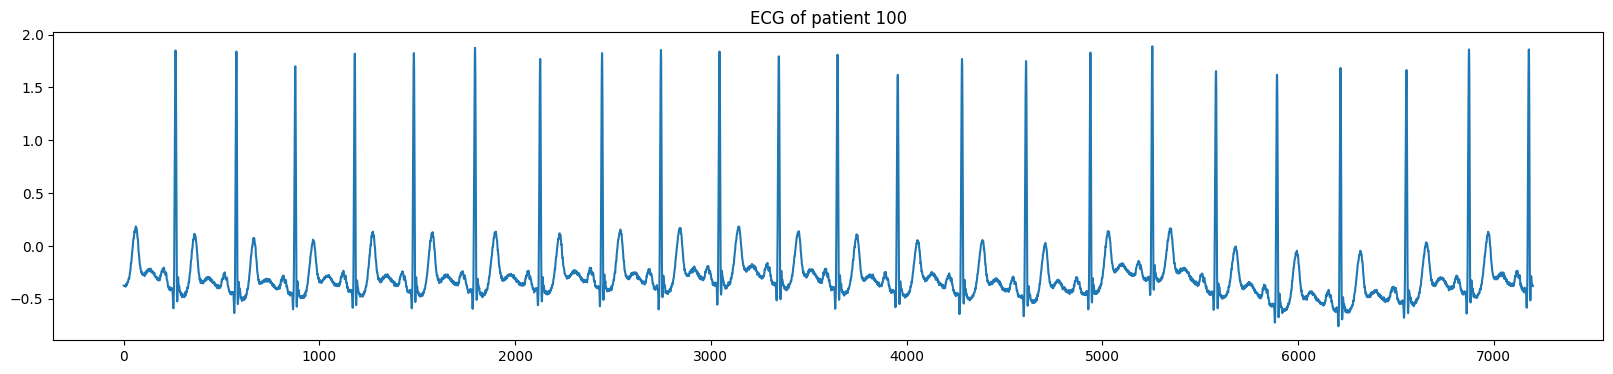

In [ ]:
plt.figure(figsize=(20, 4))
plt.plot(ecg100["MLII"][:7200])
plt.title("ECG of patient 100")
plt.show()

In [ ]:
### ChatGPT was used to help code

import matplotlib.pyplot as plt
import numpy as np
import gym
import pandas as pd
import csv
import openpyxl
import matplotlib.pyplot as plt
import pywt

from scipy.signal import find_peaks
from scipy.signal import savgol_filter

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
train_data = ecg100['MLII'][:6000]
test_data = ecg100['MLII'][6000:7200]

# Reinforcement Learning Model

In [ ]:
class ECGForecastEnv:
    def __init__(self, data, window_size, spike_penalty_weight, spike_threshold, smoothness_weight):
        self.data = data
        self.window_size = window_size
        self.current_step = 0
        self.current_state = None
        self.spike_penalty_weight = spike_penalty_weight
        self.spike_threshold = spike_threshold
        self.smoothness_weight = smoothness_weight

    def reset(self):
        self.current_step = 0
        self.current_state = self.data[self.current_step: self.current_step + self.window_size]
        return self.current_state

    def calculate_reward(self, forecasted_value, true_value):
        error = np.abs(forecasted_value - true_value)
        spike_penalty = self.spike_penalty_weight * (error > self.spike_threshold)
        smoothness_reward = -self.smoothness_weight * np.abs(forecasted_value - np.mean(self.current_state))
        total_reward = 1.0 / (error + 1e-6) + spike_penalty + smoothness_reward
        return total_reward

    def step(self, action):
        self.current_step += 1
        forecasted_value = np.mean(self.current_state) + action  # Adjust forecast based on the action
        true_value = self.data[self.current_step + self.window_size]
        reward = self.calculate_reward(forecasted_value, true_value)
        done = self.current_step >= len(self.data) - self.window_size - 1

        # Update the current state with the newly observed value
        self.current_state = np.roll(self.current_state, -1)
        self.current_state[-1] = forecasted_value

        return self.current_state, reward, done, {}


class QLearningAgent:
    def __init__(self, learning_rate=0.1, discount_factor=0.95, epsilon=0.3):
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.action_space = np.linspace(-0.1, 0.1, 21)  # Number of discrete actions for amplitude adjustments
        self.state_weights = np.random.rand(num_time_steps)  # Initialize state-action weights
        self.state_window = np.zeros(num_time_steps)  # Initialize the sliding window for state representation

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(len(self.action_space))  # Choose a random action
        else:
            q_values = np.dot(self.state_weights, state)  # Use state-action weights
            action_idx = np.argmax(q_values)  # Choose the action with the highest Q-value
            return action_idx

    def update_q_table(self, state, action, reward, next_state):
        # Calculate the target Q-value using the Bellman equation
        target_q_value = reward + self.discount_factor * np.max(np.dot(self.state_weights, next_state))

        td_error = target_q_value - np.dot(self.state_weights, state)  # Use state-action weights
        self.state_weights += self.learning_rate * td_error * state

In [ ]:
### Fix train_data: Denoise, R-Peaks and Alignment, mean, standard dev, RR

#### DENOISE THE ECG WITH WAVELET DECOMPOSITION
# Generate a synthetic ECG signal (replace this with your actual data)
fs = 1/0.002  # Sampling frequency (Hz)
t = np.arange(0, 6000) / fs  # Time vector based on signal length
ecg_signal = np.array(train_data).reshape(-1)  # Replace with your actual ECG data
# Choose wavelet and decomposition level
wavelet_name = 'db4'  # Daubechies 4
level = 5
# Perform wavelet decomposition
coeffs = pywt.wavedec(ecg_signal, wavelet_name, level=level)
# Apply thresholding to denoise the wavelet coefficients
threshold = 0.2  # Adjust this threshold value as needed
denoised_coeffs = [pywt.threshold(c, value=threshold, mode='soft') for c in coeffs]
# Reconstruct the denoised ECG signal using inverse wavelet transform
denoised_signal = pywt.waverec(denoised_coeffs, wavelet_name)

#### DETERMINE R-PEAKS AND ALSO ALIGN R-PEAK TO TIME ZERO
# Generate a synthetic ECG signal (replace this with your actual data)
fs = 1/0.002  # Sampling frequency (Hz)
t = np.arange(0, 8000) / fs  # Time vector based on signal length
ecg_signal = denoised_signal
#### Find R-Peak and Align R-Peak to zeros
# Find the relatively highest points (R-peaks) in the ECG signal
r_peak_indices, _ = find_peaks(ecg_signal, height=0, distance=300)
# Sort the R-peak indices in ascending order
r_peak_indices_sorted = sorted(r_peak_indices)
# Remove the first R-peak index
r_peak_indices_sorted = r_peak_indices_sorted[1:]
# Find the index corresponding to the second R-peak occurrence
second_r_peak_index = r_peak_indices_sorted[0]  # Now this is the first element
# Set the second R-peak occurrence at time 0
time_shift = -t[second_r_peak_index]
t_shifted = t + time_shift
# Find the index corresponding to time 0
zero_index = np.argmax(t_shifted >= 0)
ecg_signal = ecg_signal[zero_index:]

#### Calculate the mean and standard deviation and RR distance
mean_value = np.mean(ecg_signal)
std_deviation = np.std(ecg_signal)
print("Mean:", mean_value)
print("Standard Deviation:", std_deviation)
# Find R-peaks using scipy's find_peaks
peaks, _ = find_peaks(ecg_signal, height=0, distance=300)
# Calculate the number of samples between consecutive R-peaks
samples_between_rpeaks = np.diff(peaks)
average_samples_between_rpeaks = np.mean(samples_between_rpeaks)
print("Averge between R-peaks: ", average_samples_between_rpeaks)

Mean: -0.22723932233735056
Standard Deviation: 0.28021596232876544
Averge between R-peaks:  334.4


5424


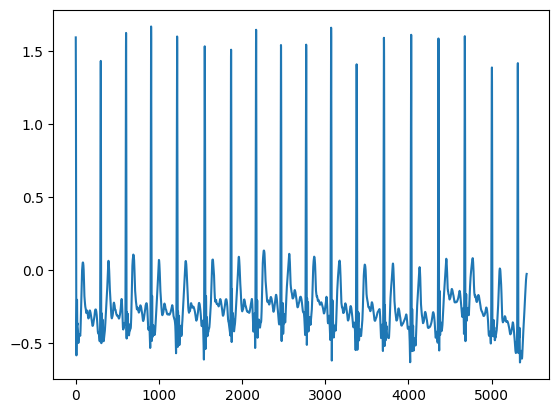

In [ ]:
print(len(ecg_signal))
plt.plot(ecg_signal)
plt.show()

# Training

In [ ]:
# TRAIN the Model
num_time_steps = 5 #int(average_samples_between_rpeaks) #len(ecg_signal)
X_fake_ecg = ecg_signal

# Create the environment
#env = ECGForecastEnv(data=X_fake_ecg, window_size=num_time_steps)
#env = ECGForecastEnv(data=X_fake_ecg, window_size=num_time_steps, spike_penalty_weight=10)
env = ECGForecastEnv(data=X_fake_ecg, window_size=5, spike_penalty_weight=10, spike_threshold=0.5, smoothness_weight=0.1)

# Create the Q-learning agent
agent = QLearningAgent()

# Train the agent with Q-learning
num_episodes = 250
total_rewards = np.zeros(num_episodes)  # Track total rewards for each episode

for episode in range(num_episodes):
    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = agent.choose_action(state)

        # Clip the action to ensure it falls within the valid range
        action = max(min(action, len(agent.action_space) - 1), 0)

        next_state, reward, done, _ = env.step(action)
        agent.update_q_table(state, action, reward, next_state)
        total_reward += reward
        state = next_state

    total_rewards[episode] = total_reward

    print(f"Episode {episode + 1} - Total Reward: {total_reward}")

print("Training completed.")

<ipython-input-406-7e856d248f1d>:61: RuntimeWarning: invalid value encountered in double_scalars
  td_error = target_q_value - np.dot(self.state_weights, state)  # Use state-action weights


Episode 1 - Total Reward: 52586.77012147507
Episode 2 - Total Reward: 52612.84495272157
Episode 3 - Total Reward: 52492.831329421846
Episode 4 - Total Reward: 52492.98709221834
Episode 5 - Total Reward: 52548.622194725416
Episode 6 - Total Reward: 52627.89044831561
Episode 7 - Total Reward: 52632.14412795444
Episode 8 - Total Reward: 52543.67833853637
Episode 9 - Total Reward: 52522.41605773563
Episode 10 - Total Reward: 52673.18296451632
Episode 11 - Total Reward: 52580.00463459601
Episode 12 - Total Reward: 52573.70419538696
Episode 13 - Total Reward: 52540.28836669949
Episode 14 - Total Reward: 52597.13638925605
Episode 15 - Total Reward: 52554.3295258047
Episode 16 - Total Reward: 52580.23081541459
Episode 17 - Total Reward: 52571.40765785082
Episode 18 - Total Reward: 52573.15810740148
Episode 19 - Total Reward: 52634.88212681871
Episode 20 - Total Reward: 52525.544477223186
Episode 21 - Total Reward: 52620.87612540599
Episode 22 - Total Reward: 52611.03695185798
Episode 23 - Tota

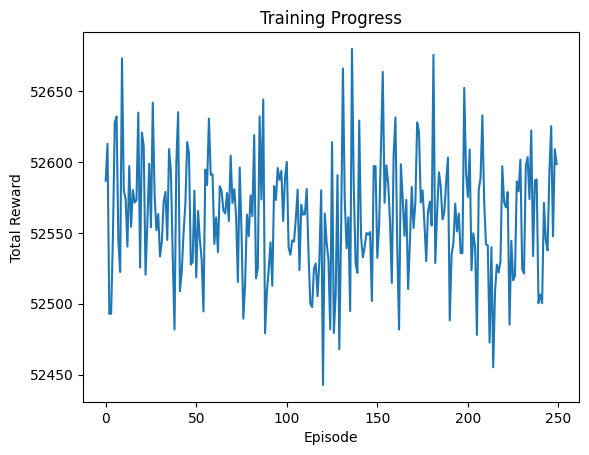

In [ ]:
plt.plot(total_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Progress')
plt.show()

# Test

In [ ]:
### Fix train_data: Denoise, R-Peaks and Alignment, mean, standard dev, RR

#### DENOISE THE ECG WITH WAVELET DECOMPOSITION
# Generate a synthetic ECG signal (replace this with your actual data)
fs = 1/0.002  # Sampling frequency (Hz)
t = np.arange(0, 1200) / fs  # Time vector based on signal length
ecg_signal = np.array(test_data).reshape(-1)  # Replace with your actual ECG data
# Choose wavelet and decomposition level
wavelet_name = 'db4'  # Daubechies 4
level = 5
# Perform wavelet decomposition
coeffs = pywt.wavedec(ecg_signal, wavelet_name, level=level)
# Apply thresholding to denoise the wavelet coefficients
threshold = 0.2  # Adjust this threshold value as needed
denoised_coeffs = [pywt.threshold(c, value=threshold, mode='soft') for c in coeffs]
# Reconstruct the denoised ECG signal using inverse wavelet transform
denoised_signal = pywt.waverec(denoised_coeffs, wavelet_name)

#### DETERMINE R-PEAKS AND ALSO ALIGN R-PEAK TO TIME ZERO
# Generate a synthetic ECG signal (replace this with your actual data)
fs = 1/0.002  # Sampling frequency (Hz)
t = np.arange(0, 2000) / fs  # Time vector based on signal length
ecg_signal = denoised_signal
#### Find R-Peak and Align R-Peak to zeros
# Find the relatively highest points (R-peaks) in the ECG signal
r_peak_indices, _ = find_peaks(ecg_signal, height=0, distance=300)
# Sort the R-peak indices in ascending order
r_peak_indices_sorted = sorted(r_peak_indices)
# Remove the first R-peak index
r_peak_indices_sorted = r_peak_indices_sorted[1:]
# Find the index corresponding to the second R-peak occurrence
second_r_peak_index = r_peak_indices_sorted[0]  # Now this is the first element
# Set the second R-peak occurrence at time 0
time_shift = -t[second_r_peak_index]
t_shifted = t + time_shift
# Find the index corresponding to time 0
zero_index = np.argmax(t_shifted >= 0)
ecg_signal = ecg_signal[zero_index:]

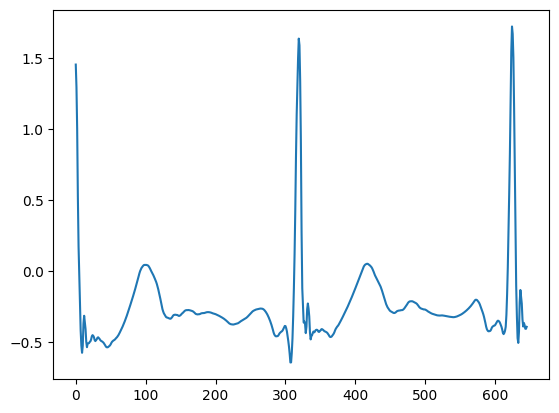

[ 217  554  873 1178]


In [ ]:
plt.plot(ecg_signal)
plt.show()

print(r_peak_indices)

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate the Mean Absolute Percentage Error (MAPE).

    Parameters:
    - y_true: array-like, actual values.
    - y_pred: array-like, predicted values.

    Returns:
    - mape: float, Mean Absolute Percentage Error.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    # Avoid division by zero
    mask = y_true != 0
    y_true, y_pred = y_true[mask], y_pred[mask]

    # Calculate absolute percentage error
    ape = np.abs((y_true - y_pred) / y_true)

    # Calculate mean absolute percentage error
    mape = np.mean(ape)

    return mape

def rmse(y_true, y_pred):
    """
    Calculate the Root Mean Squared Error (RMSE).

    Parameters:
    - y_true: array-like, actual values.
    - y_pred: array-like, predicted values.

    Returns:
    - rmse: float, Root Mean Squared Error.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    # Calculate squared differences
    squared_diff = (y_true - y_pred)**2

    # Calculate mean squared difference
    mean_squared_diff = np.mean(squared_diff)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_diff)

    return rmse

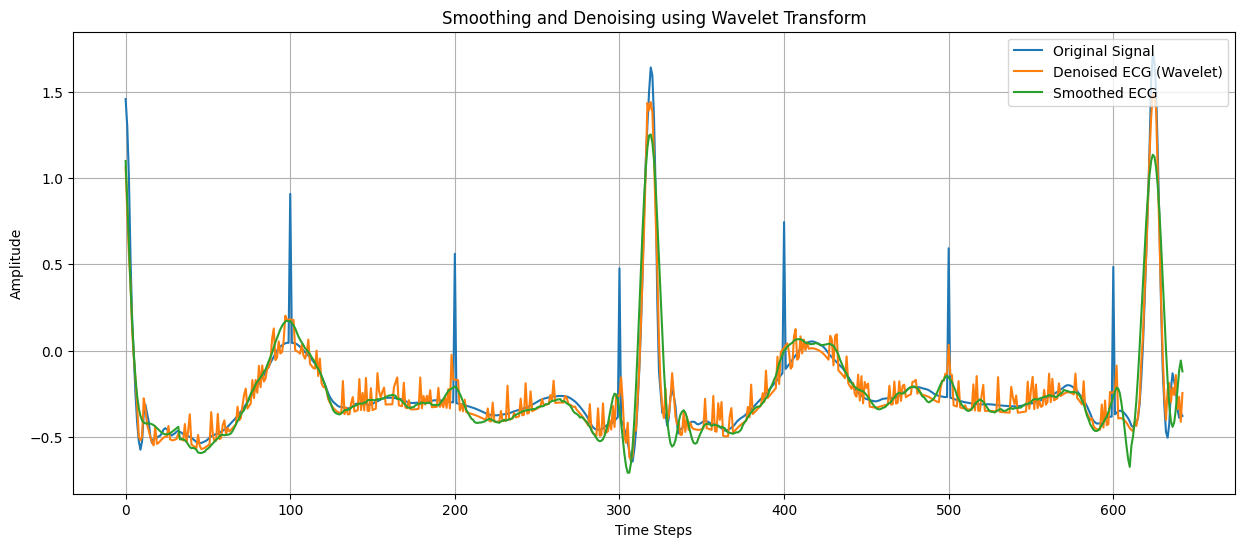

threshold: 0.7005399058219136
train data mean: -0.22723932233735056 train data std: 0.28021596232876544

MAPE: 0.5965636683559588
RMSE: 0.11047686700184542

real bump indices: [100 200 300 400 500 600]
real bump distances: [0.7372474052029021, 0.7686480713000406, 0.8191239382091248, 0.7463646741331471, 0.7496701186802637, 0.755952493322904]
predicted bump indices: [100 200 300 400 500 600]

Number of measurement above threshold:  6
Accuracy (with original being 20 total):  100.0


In [ ]:
### Add anomaly
# Generate a synthetic ECG signal (replace this with your actual data)
fs = 1/0.002  # Sampling frequency (Hz)
#ecg_signal = np.array(test_data).reshape(-1)  # Replace with your actual ECG data
t = np.arange(0, len(ecg_signal)) / fs  # Time vector based on signal length
amplitude = mean_value + 3 * std_deviation

# Create a sinusoidal time series
original_time_series = ecg_signal

# Define parameters for the periodic bump
bump_period = 100*0.002  # Period of the bump (in seconds)
bump_duration = 0.002  # Duration of each bump (in seconds)
bump_amplitude = max(0.5, max(ecg_signal)/2)  # Amplitude of the bump

# Convert bump period from seconds to samples
bump_period_samples = int(bump_period * fs)

# Create a bump pattern
bump_pattern = np.zeros_like(t)
bump_indices = np.arange(100, len(t), bump_period_samples)
for idx in bump_indices:
    bump_pattern[idx:idx+int(bump_duration * fs)] = bump_amplitude

# Add the bump pattern to the original time series
time_series_with_bumps = original_time_series + bump_pattern

# Perform inference with the trained agent (forecasting ECG data)
X_fake_ecg = time_series_with_bumps
num_time_steps = 3 #int(average_samples_between_rpeaks)
state = env.reset()
predicted_ecg = []

while len(predicted_ecg) < len(X_fake_ecg) - num_time_steps:  # Adjust loop to match data lengths
    action = agent.choose_action(state)

    # Append the forecasted value to the list of predicted ECG values
    forecasted_value = np.mean(state) + agent.action_space[action]  # Use weighted average for forecasting
    predicted_ecg.append(float(forecasted_value))  # Convert the scalar value to float

    # Update the current state with the newly observed value
    state = np.roll(state, -1)
    state[-1] = X_fake_ecg[len(predicted_ecg) + num_time_steps - 1]  # Use the true value for forecasting

min_length = min(len(X_fake_ecg), len(predicted_ecg))
time = np.arange(min_length)
X_fake_ecg = X_fake_ecg[:min_length]
predicted_ecg = predicted_ecg[:min_length]
original_time_series = original_time_series[:min_length]

# Choose wavelet and decomposition level
wavelet_name = 'db4'  # Daubechies 4
level = 5
coeffs = pywt.wavedec(predicted_ecg, wavelet_name, level=level)
threshold = 0.0000  # Adjust this threshold value as needed
denoised_coeffs = [pywt.threshold(c, value=threshold, mode='hard') for c in coeffs]
denoised_ecg = pywt.waverec(denoised_coeffs, wavelet_name)

# Smooth the signal
window_size = 67  # Must be an odd number
order = 10  # Polynomial order
smoothed_ecg = savgol_filter(denoised_ecg, window_size, order)


difference = np.mean(original_time_series) - np.mean(smoothed_ecg)
smoothed_ecg = smoothed_ecg + difference

difference = np.mean(original_time_series) - np.mean(denoised_ecg)
denoised_ecg = denoised_ecg + difference

min_length = min(len(time), len(denoised_ecg), len(smoothed_ecg))
time = time[:min_length]
denoised_ecg = denoised_ecg[:min_length]
smoothed_ecg = smoothed_ecg[:min_length]

# Plot the original, smoothed, and denoised signals
plt.figure(figsize=(15, 6))
plt.plot(time, X_fake_ecg, label='Original Signal')
plt.plot(time, denoised_ecg, label='Denoised ECG (Wavelet)')
plt.plot(time, smoothed_ecg, label='Smoothed ECG')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.title('Smoothing and Denoising using Wavelet Transform')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Count the number of values above the threshold
distance = np.abs(X_fake_ecg - smoothed_ecg)
threshold = amplitude
threshold = (std_deviation * 2.5)
print('threshold:', threshold)
print("train data mean:",mean_value, "train data std:",std_deviation)
count_above_threshold = np.sum(distance >= threshold)
mape_result = mean_absolute_percentage_error(original_time_series, smoothed_ecg)
num_bumps = float(len(bump_indices))
print()

print("MAPE:", mape_result)
print("RMSE:", rmse(original_time_series, smoothed_ecg))
print()

print("real bump indices:", np.array(bump_indices))
print("real bump distances:", [distance[i] for i in bump_indices if i < min_length])
print("predicted bump indices:", np.where(distance >= threshold)[0])

print()
print("Number of measurement above threshold: ", count_above_threshold)

cnt = 0
for i in bump_indices:
  if i in np.where(distance >= threshold)[0]:
    cnt += 1

print("Accuracy (with original being 20 total): ", cnt / num_bumps * 100.0)

abnomaly test

In [ ]:
# Function to generate different types of anomalies
def generate_anomalies(ecg_signal, fs, bump_period_samples, bump_duration, num_anomalies):
    anomalies = np.zeros_like(ecg_signal)

    for _ in range(num_anomalies):
        # Randomly select the type of anomaly (e.g., sinusoidal, square, triangular)
        anomaly_type = np.random.choice(['sinusoidal', 'square', 'triangular'])

        # Randomly determine the start time of the anomaly
        start_time = np.random.randint(0, len(ecg_signal) - bump_period_samples)

        # Create a time vector for the anomaly
        anomaly_t = np.arange(0, bump_duration, 1/fs)

        # Generate different types of anomalies
        if anomaly_type == 'sinusoidal':
            anomaly = np.sin(2 * np.pi * 2 / bump_duration * anomaly_t)  # Adjust frequency as needed
        elif anomaly_type == 'square':
            anomaly = np.ones_like(anomaly_t)
        elif anomaly_type == 'triangular':
            anomaly = np.concatenate([np.linspace(0, 1, len(anomaly_t)//2), np.linspace(1, 0, len(anomaly_t)//2)])

        # Insert the anomaly into the signal
        anomalies[start_time:start_time + len(anomaly)] += anomaly

    # Clip values to ensure the anomalies do not exceed the signal range
    anomalies = np.clip(anomalies, np.min(ecg_signal), np.max(ecg_signal))

    return anomalies

indice 확인 (array([347, 390]),)


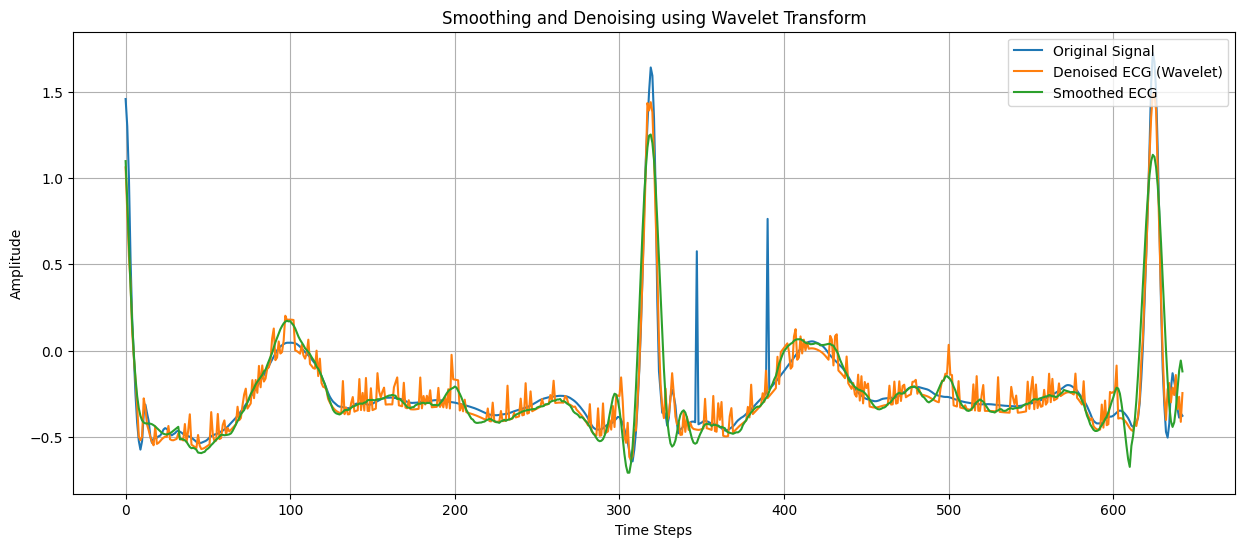

threshold: 0.7005399058219136
train data mean: -0.22723932233735056 train data std: 0.28021596232876544

MAPE: 0.5917190472783875
RMSE: 0.11047771270089868

real bump indices: [[347 390]]
real bump distances: [array([1.1097188 , 1.02564085])]
predicted bump indices: [347 390]

Number of measurement above threshold:  2
Accuracy (with original being 20 total):  100.0


In [ ]:
### Add anomaly
# Generate a synthetic ECG signal (replace this with your actual data)
fs = 1/0.002  # Sampling frequency (Hz)
#ecg_signal = np.array(test_data).reshape(-1)  # Replace with your actual ECG data
t = np.arange(0, len(ecg_signal)) / fs  # Time vector based on signal length
amplitude = mean_value + 3 * std_deviation

# Create a sinusoidal time series
original_time_series = ecg_signal

# Define parameters for the periodic bump
bump_period = 100*0.002  # Period of the bump (in seconds)
bump_duration = 0.002  # Duration of each bump (in seconds)
bump_amplitude = max(0.5, max(ecg_signal)/2)  # Amplitude of the bump

# Convert bump period from seconds to samples
bump_period_samples = int(bump_period * fs)

# Number of different anomalies to introduce
num_anomalies = 3

# Generate anomalies and add them to the original signal
anomalies = generate_anomalies(ecg_signal, fs, bump_period_samples, bump_duration, num_anomalies)
bump_indices = np.where(anomalies != 0)
print('indice 확인', bump_indices)
ecg_signal_with_anomalies = ecg_signal + anomalies


# Choose wavelet and decomposition level
wavelet_name = 'db4'  # Daubechies 4
level = 5
coeffs = pywt.wavedec(predicted_ecg, wavelet_name, level=level)
threshold = 0.0000  # Adjust this threshold value as needed
denoised_coeffs = [pywt.threshold(c, value=threshold, mode='hard') for c in coeffs]
denoised_ecg = pywt.waverec(denoised_coeffs, wavelet_name)

# Smooth the signal
window_size = 67  # Must be an odd number
order = 10  # Polynomial order
smoothed_ecg = savgol_filter(denoised_ecg, window_size, order)


difference = np.mean(original_time_series) - np.mean(smoothed_ecg)
smoothed_ecg = smoothed_ecg + difference

difference = np.mean(original_time_series) - np.mean(denoised_ecg)
denoised_ecg = denoised_ecg + difference

min_length = min(len(time), len(denoised_ecg), len(smoothed_ecg))
time = time[:min_length]
denoised_ecg = denoised_ecg[:min_length]
smoothed_ecg = smoothed_ecg[:min_length]
ecg_signal_with_anomalies = ecg_signal_with_anomalies[:min_length]
original_time_series = original_time_series[:min_length]

# Plot the original, smoothed, and denoised signals
plt.figure(figsize=(15, 6))
plt.plot(time, ecg_signal_with_anomalies, label='Original Signal')
plt.plot(time, denoised_ecg, label='Denoised ECG (Wavelet)')
plt.plot(time, smoothed_ecg, label='Smoothed ECG')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.title('Smoothing and Denoising using Wavelet Transform')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Count the number of values above the threshold
distance = np.abs(ecg_signal_with_anomalies - smoothed_ecg)
threshold = amplitude
threshold = (std_deviation * 2.5)
print('threshold:', threshold)
print("train data mean:",mean_value, "train data std:",std_deviation)
count_above_threshold = np.sum(distance >= threshold)
mape_result = mean_absolute_percentage_error(original_time_series, smoothed_ecg)
num_bumps = float(len(bump_indices))
print()

print("MAPE:", mape_result)
print("RMSE:", rmse(original_time_series, smoothed_ecg))
print()

print("real bump indices:", np.array(bump_indices))
print("real bump distances:", [distance[i] for i in bump_indices])
print("predicted bump indices:", np.where(distance >= threshold)[0])

print()
print("Number of measurement above threshold: ", count_above_threshold)

cnt = 0
for i in bump_indices:
  if i in np.where(distance >= threshold)[0]:
    cnt += 1

print("Accuracy (with original being 20 total): ", cnt / num_bumps * 100.0)